<h1> CREAZIONE MODELLO SARIMA ROMANIA

In [1]:
import pandas as pd
df = pd.read_csv('../../csv/nazioni/serie_storica_ro.csv')
df.head()

,TIME,GEO,Value
0,2015-01-05,Romania,5803
1,2015-01-12,Romania,5848
2,2015-01-19,Romania,5602
3,2015-01-26,Romania,5508
4,2015-02-02,Romania,5560


In [2]:
df['TIME'] = pd.to_datetime(df['TIME'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    300 non-null    datetime64[ns]
 1   GEO     300 non-null    object        
 2   Value   300 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 7.2+ KB


In [4]:
df=df.set_index('TIME')
df.head()

,GEO,Value
TIME,,
2015-01-05,Romania,5803
2015-01-12,Romania,5848
2015-01-19,Romania,5602
2015-01-26,Romania,5508
2015-02-02,Romania,5560


<h3>Creazione serie storica dei decessi totali

In [5]:
df = df.groupby(pd.Grouper(freq='M')).sum()
df.head()

,Value
TIME,
2015-01-31,22761
2015-02-28,23344
2015-03-31,29581
2015-04-30,21710
2015-05-31,19311


In [6]:
ts = df.Value
ts.head()

TIME
2015-01-31    22761
2015-02-28    23344
2015-03-31    29581
2015-04-30    21710
2015-05-31    19311
Freq: M, Name: Value, dtype: int64

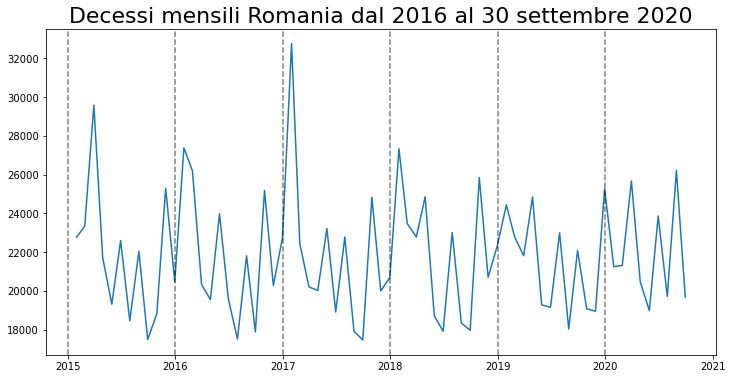

In [7]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,9,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili Romania dal 2016 al 30 settembre 2020', size=22)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Decomposizione

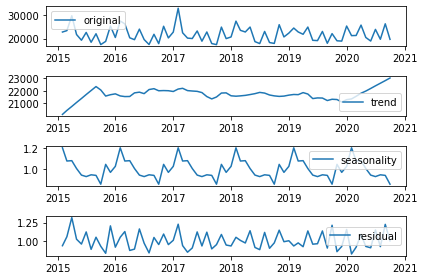

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False

<h3>Test di stazionarietà

In [10]:
test_stationarity(ts)

X is stationary


True

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2015 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [11]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,8,30)


In [12]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

X is not stationary
X is stationary
1


<h3>Grafici di Autocorrelazione e Autocorrelazione Parziale

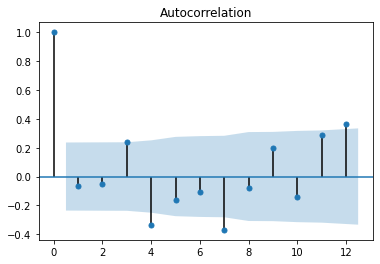

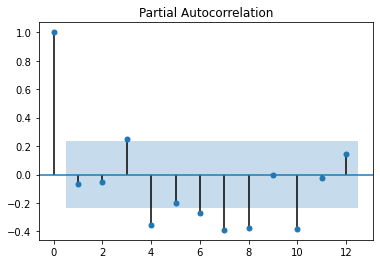

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(12,0,8))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   58
Model:              SARIMAX(12, 0, 8)   Log Likelihood                -543.658
Date:                Wed, 10 Mar 2021   AIC                           1129.317
Time:                        10:50:41   BIC                           1172.586
Sample:                    01-31-2015   HQIC                          1146.171
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2669      1.634     -0.163      0.870      -3.470       2.936
ar.L2          0.1951      0.987      0.198      0.843      -1.740       2.130
ar.L3          0.1478      0.545      0.271      0.7

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>Verifica della stazionarietà dei residui del modello ottenuto

In [15]:
residuals = model_fit.resid
test_stationarity(residuals)

X is stationary


True

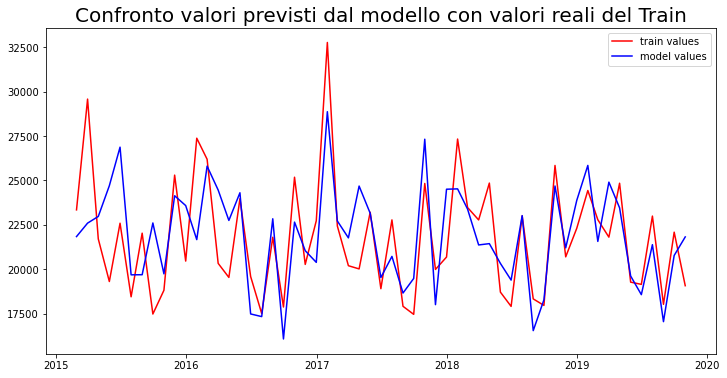

In [16]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()


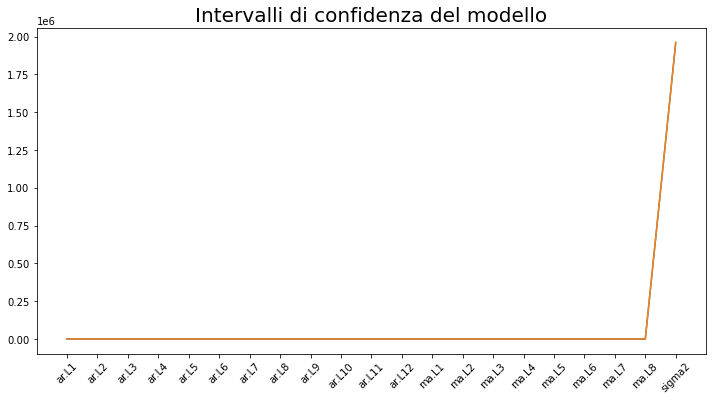

In [17]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h3>Predizione del modello sul Test

In [18]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-30 00:00:00


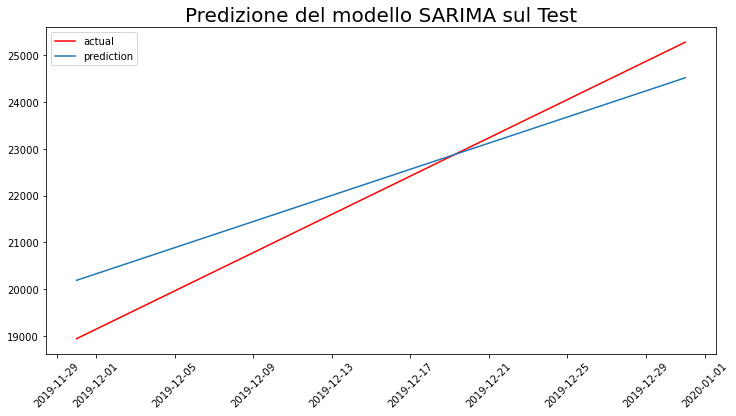

2019-11-30    20190.170617
2019-12-31    24513.076623
Freq: M, Name: predicted_mean, dtype: float64


In [19]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]


#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)


plt.figure(figsize=(12,6))
plt.title('Predizione del modello SARIMA sul Test', size=20)
plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

In [20]:
# Accuracy metrics
import numpy as np
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE: errore percentuale medio assoluto
    me = np.mean(forecast - actual)             # ME: errore medio
    mae = np.mean(np.abs(forecast - actual))    # MAE: errore assoluto medio
    mpe = np.mean((forecast - actual)/actual)   # MPE: errore percentuale medio
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr: correlazione tra effettivo e previsione
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax: errore min-max
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions_test, test)

{'mape': 0.04792519829220571,
 'me': 243.1236202591772,
 'mae': 1003.0469972177507,
 'mpe': 0.017856612174270627,
 'rmse': 1032.091262125339,
 'corr': 1.0,
 'minmax': 0.04589511739490015}

In [21]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('NRMSE: %f'% nrmse)

NRMSE: 0.163073


<h2>Predizione del modello compreso l'anno 2020

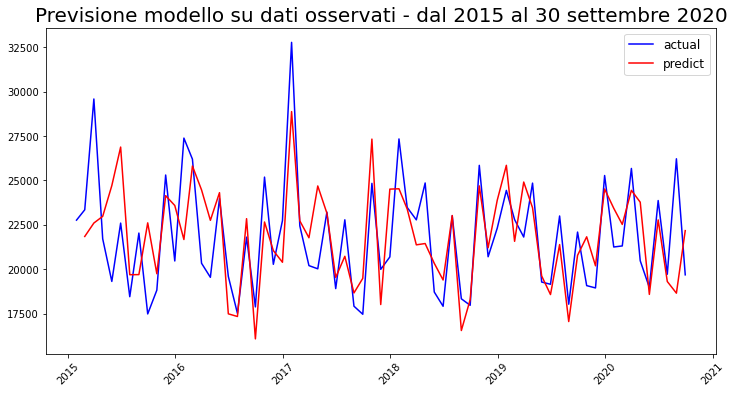

In [22]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 settembre 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

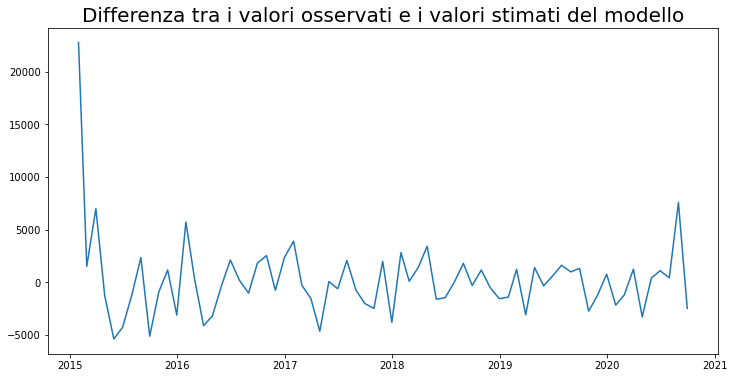

In [23]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [24]:
diff_predictions_tot['24-02-2020':].sum()

3689.4584473687064

In [25]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_ro.csv')

<h2>Intervalli di confidenza della previsione totale

In [26]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower Value'])

2015-01-31        0.000000
2015-02-28    21841.345409
2015-03-31    22598.167026
2015-04-30    22974.089622
2015-05-31    24704.594873
                  ...     
2020-05-31    18580.605796
2020-06-30    22774.246961
2020-07-31    19305.958158
2020-08-31    18649.972552
2020-09-30    22170.917009
Freq: M, Name: predicted_mean, Length: 69, dtype: float64
             lower Value   upper Value
2015-01-31 -33617.067534  33617.067534
2015-02-28  12382.029979  31300.660840
2015-03-31  14685.348828  30510.985225
2015-04-30  17661.986749  28286.192495
2015-05-31  19455.894465  29953.295281
...                  ...           ...
2020-05-31  15470.870997  21690.340596
2020-06-30  19574.953621  25973.540301
2020-07-31  16101.199280  22510.717036
2020-08-31  15172.776277  22127.168827
2020-09-30  18682.475557  25659.358462

[69 rows x 2 columns]
2015-01-31    33617.067534
2015-02-28     9459.315430
2015-03-31     7912.818199
2015-04-30     5312.102873
2015-05-31     5248.700408
                  .

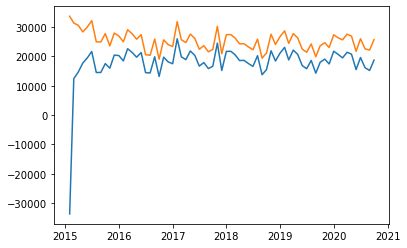

In [27]:
plt.plot(in_c)
plt.show()

In [28]:
upper = in_c['upper Value']
lower = in_c['lower Value']

In [29]:
lower.to_csv('../../csv/lower/predictions_SARIMA_ro_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_ro_upper.csv')